
# CIS 5450 Final Project - NBA Points Predictor

*Grant Wells, Ayo Tobun*

# Introduction and Background



In this project, we will be using data pulled from www.NBA.com using the nba_api API client package (https://github.com/swar/nba_api) to predict our target variable PTS (points scored in a given game). This API accesses data directly from the NBA's website, which has an extensive collection of information on every game and player.

Whether you are a sports bettor, sports analyst, or involved directly with the NBA through coaching or advising, or just an avid fan, being able to get a general prediction on how many points a player will score in a given game could provide amazing insights.

For example, imagine you are a bettor looking at LeBron's over/under line set at 24.5 points. You are unsure if LeBron will have an amazing game and score more than 24.5, or if he will bust and score less.

On the other hand, imagine you are an analyst ranking the expected top performances of the week for the media, and you want to be able to get general predictions on how many points certain players will score.

Or, you could be a coach deciding on which player you'd like to start in a given game- the rookie who has been on a tear, or the veteran who is finally back from injury.

In all of these cases, having a model that gives you a general indication of how many points a player will score in a given game with only using features that can be calculated before the game could be very useful.

Our objective will be to create models that do just that!

Let's begin with some installations and imports.

In [1]:
# Installations

! pip install nba_api
! pip install pandasql
! pip install scikit-optimize

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from skopt import BayesSearchCV

# Data Collection

## Game Logs

The primary data that we will be analyzing for this project is indiviudal game logs from every player in every game starting from the 2009-10 season until 2021-22 using the *playergamelogs* endpoint from the *nba_api*. Note that we will be excluding the COVID-19 season, 2019-20, as this atypical season is surely an outlier due to the playing conditions.

In [3]:
from nba_api.stats.endpoints import playergamelogs

# All seasons from 2009 to 2022 excluding covid season (2019-20)
seasons = [
    '2009-10',
    '2010-11',
    '2011-12',
    '2012-13',
    '2013-14',
    '2014-15',
    '2015-16',
    '2016-17',
    '2017-18',
    '2018-19',
    '2020-21',
    '2021-22'
]

all_seasons_df = pd.DataFrame()

# Loop through each season
for season in seasons:
  # Fetch game logs for all players for the specified season
  game_logs = playergamelogs.PlayerGameLogs(season_nullable=season)
  # Get the df
  game_logs_df = game_logs.get_data_frames()[0]
  # Concatenate current season's info to the big df
  all_seasons_df = pd.concat([all_seasons_df, game_logs_df], ignore_index=True)

# Regex pattern to extract second team from matchup (opponent team)
pattern = r'(?<=\s)(?:vs\.|@)\s(.*)$'
# Use the regex pattern to store opponent team
all_seasons_df['OPP'] = all_seasons_df['MATCHUP'].apply(lambda matchup: re.search(pattern, matchup).group(1))


all_seasons_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,OPP
0,2009-10,201588,George Hill,George,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,1,18272,14602,9384,20518,2160,24,20041,None,DAL
1,2009-10,1717,Dirk Nowitzki,Dirk,1610612742,DAL,Dallas Mavericks,0020901220,2010-04-14T00:00:00,DAL vs. SAS,...,9903,8143,3296,4889,5275,2160,24,4944,None,SAS
2,2009-10,200757,Thabo Sefolosha,Thabo,1610612760,OKC,Oklahoma City Thunder,0020901224,2010-04-14T00:00:00,OKC vs. MEM,...,1,18272,10123,7637,15850,2160,24,13857,None,MEM
3,2009-10,201238,Mario West,Mario,1610612737,ATL,Atlanta Hawks,0020901217,2010-04-14T00:00:00,ATL vs. CLE,...,20228,8143,10123,477,7440,2160,24,8634,None,CLE
4,2009-10,201566,Russell Westbrook,Russell,1610612760,OKC,Oklahoma City Thunder,0020901224,2010-04-14T00:00:00,OKC vs. MEM,...,15686,5091,11246,4311,6976,2160,24,7471,None,MEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301593,2021-22,1629673,Jordan Poole,Jordan,1610612744,GSW,Golden State Warriors,0022100002,2021-10-19T00:00:00,GSW @ LAL,...,11965,4544,3410,10189,7727,2151,131,5470,1,LAL
301594,2021-22,203076,Anthony Davis,Anthony,1610612747,LAL,Los Angeles Lakers,0022100002,2021-10-19T00:00:00,LAL vs. GSW,...,1,2687,384,14276,397,1,131,534,1,GSW
301595,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100002,2021-10-19T00:00:00,LAL vs. GSW,...,24672,276,322,14276,467,1,131,252,1,GSW
301596,2021-22,201142,Kevin Durant,Kevin,1610612751,BKN,Brooklyn Nets,0022100001,2021-10-19T00:00:00,BKN @ MIL,...,11965,1601,475,24871,495,1,131,461,1,MIL


## Team Stats

Another helpful endpoint from the nba_api is *teamgamelogs*, which we can leverage to calculate the amount of points on average a team let up to their opponents per season.

In [4]:
from nba_api.stats.endpoints import teamgamelogs

points_allowed_df = pd.DataFrame()

# Loop through seasons
for season in seasons:
  # Fetch game logs for all teams for the specified season
  #print("trying for", season)
  team_game_logs = teamgamelogs.TeamGameLogs(season_nullable=season).get_data_frames()[0]

  # Regex pattern to extract second team from matchup (opponent team) using
  # positive look behind to find the vs. or @, non capture group to skip,
  # and then finally a capture group at the end to extract the 2nd team (opponent)
  pattern = r'(?<=\s)(?:vs\.|@)\s(.*)$'

  # Use the regex pattern to store opponent team
  team_game_logs['OPP'] = team_game_logs['MATCHUP'].apply(lambda matchup: re.search(pattern, matchup).group(1))

  # Create a copy of the DataFrame to calculate opponent's points
  opponent_pts = team_game_logs[['GAME_ID', 'TEAM_ID', 'PTS']].copy()
  opponent_pts.rename(columns={'TEAM_ID': 'OPPONENT_ID', 'PTS': 'OPP_PTS'}, inplace=True)

  # INNER JOIN the original game logs with this opponent points DataFrame on GAME_ID
  merged_data = pd.merge(team_game_logs, opponent_pts, on='GAME_ID')

  # Get rid of rows where the team ID and opponent ID are the same since we want opponent points
  final_data = merged_data[merged_data['TEAM_ID'] != merged_data['OPPONENT_ID']]

  # Group by team and calculate average points allowed
  avg_points_allowed = final_data.groupby('TEAM_ABBREVIATION')['OPP_PTS'].mean().reset_index()

  # Rename columns for clarity
  avg_points_allowed.columns = ['OPP', 'PTS_ALLOWED']

  # Add the year column
  avg_points_allowed['SEASON_YEAR'] = season

  # Sort for aesthetics
  avg_points_allowed.sort_values(inplace=True, by='PTS_ALLOWED', ascending=True)

  # Reset and drop index
  avg_points_allowed.reset_index(drop=True, inplace=True)

  # Concatenate to the bigger df
  points_allowed_df = pd.concat([points_allowed_df, avg_points_allowed], ignore_index=True)

points_allowed_df


,OPP,PTS_ALLOWED,SEASON_YEAR
0,CHA,93.817073,2009-10
1,MIA,94.231707,2009-10
2,POR,94.804878,2009-10
3,ORL,95.268293,2009-10
4,BOS,95.560976,2009-10
...,...,...,...
355,IND,114.939024,2021-22
356,POR,115.109756,2021-22
357,LAL,115.146341,2021-22
358,SAC,115.768293,2021-22


Now that we have the average points allowed by each team to their opponents for all of the given seasons, we can use INNER JOIN this with the individual player game logs to now have a feature that allows us to see how many points per game their opponent gives up on average, which should be a helpful feature.

In [5]:
# INNER JOIN to merge the data frames to get the points allowed for each opponent in the player game logs

cleaned_logs_df = pd.merge(all_seasons_df, points_allowed_df, on=['OPP', 'SEASON_YEAR'], how='inner')

cleaned_logs_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,OPP,PTS_ALLOWED
0,2009-10,201588,George Hill,George,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,18272,14602,9384,20518,2160,24,20041,None,DAL,99.280488
1,2009-10,201971,DeJuan Blair,DeJuan,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,5091,811,4311,50,1,24,69,None,DAL,99.280488
2,2009-10,686,Antonio McDyess,Antonio,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,18272,17107,12519,12250,2160,24,12550,None,DAL,99.280488
3,2009-10,202066,Garrett Temple,Garrett,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,8143,6433,14639,8240,2160,24,8016,None,DAL,99.280488
4,2009-10,2427,Roger Mason Jr.,Roger,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,12463,19633,13559,13225,2160,24,14590,None,DAL,99.280488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301593,2021-22,1630552,Jalen Johnson,Jalen,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,18239,15707,13253,20535,2151,131,18903,1,DAL,104.719512
301594,2021-22,1630219,Skylar Mays,Skylar,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,11915,19908,13253,22929,2151,131,22194,1,DAL,104.719512
301595,2021-22,1629629,Cam Reddish,Cam,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,4544,3410,2767,9364,2151,131,6398,1,DAL,104.719512
301596,2021-22,203991,Clint Capela,Clint,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,7362,8935,1837,5500,1,131,6398,1,DAL,104.719512


Using these two endpoints, we now have a fairly large starting dataset with around 300k rows and 70 columns containing data on every player that has played since 2009 until 2022. We can now perform some feature engineering to both modify existing features and create new ones that should help us with predicting our target variable PTS.

# Feature Engineering

As of right now, we currently have 70 columns/features, many of which can be modified, used to create new features, or completely disregarded as they are irrelevant. Note that scaling here is unecessary as all of the NBA stats we will be analyzing are already on the same scale and not too high in magnitude anyways. First, let's begin with creating and modifying features before we get rid of anything.

## Home/Away

Players can tend to have better performances depending on whether they are playing in the comfort of their home court or by finding fuel from the pressure of being in enemy territory, so we can extract the information from the 'MATCHUP' column to indicate Home as 1 and Away as 0. Matchups are either in the form "X @ Y" meaning X is playing at Y so they are away, or "X vs. Y" meaning X is playing at home, so we can use **RegEx** to extract this into a new column.

In [6]:
# RegEx pattern to extract either vs. (home) or @ (away)
pattern = r'vs\.|@'

# Use the pattern to create column 'LOCATION' to have vs. for HOME or @ for AWAY
cleaned_logs_df['LOCATION'] = cleaned_logs_df['MATCHUP'].apply(lambda matchup : re.search(pattern, matchup).group(0))

# Use OneHotEncoder to map vs. -> 1 for HOME and @ -> 0 for AWAY (similar to HW4)

categories = [['@', 'vs.']]

encoder = OneHotEncoder(drop='if_binary', sparse_output=False, categories=categories)

encoded_values = encoder.fit_transform(cleaned_logs_df[['LOCATION']])

encoded_df = pd.DataFrame(encoded_values, columns=['LOCATION'], index=cleaned_logs_df.index)

# drop the original location column to prepare for merging them back
no_location_df = cleaned_logs_df.drop('LOCATION', axis=1)

cleaned_logs_df = pd.concat([no_location_df, encoded_df], axis=1)

cleaned_logs_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,OPP,PTS_ALLOWED,LOCATION
0,2009-10,201588,George Hill,George,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,14602,9384,20518,2160,24,20041,None,DAL,99.280488,0.0
1,2009-10,201971,DeJuan Blair,DeJuan,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,811,4311,50,1,24,69,None,DAL,99.280488,0.0
2,2009-10,686,Antonio McDyess,Antonio,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,17107,12519,12250,2160,24,12550,None,DAL,99.280488,0.0
3,2009-10,202066,Garrett Temple,Garrett,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,6433,14639,8240,2160,24,8016,None,DAL,99.280488,0.0
4,2009-10,2427,Roger Mason Jr.,Roger,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,19633,13559,13225,2160,24,14590,None,DAL,99.280488,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301593,2021-22,1630552,Jalen Johnson,Jalen,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,15707,13253,20535,2151,131,18903,1,DAL,104.719512,1.0
301594,2021-22,1630219,Skylar Mays,Skylar,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,19908,13253,22929,2151,131,22194,1,DAL,104.719512,1.0
301595,2021-22,1629629,Cam Reddish,Cam,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,3410,2767,9364,2151,131,6398,1,DAL,104.719512,1.0
301596,2021-22,203991,Clint Capela,Clint,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,8935,1837,5500,1,131,6398,1,DAL,104.719512,1.0


## Season Progession

Seasons in the NBA are quite long, so players tend to be more determined to win towards the end of the season when playoff seedings start being decided. We can use the 'GAME_DATE' column to first create a new column called "MONTH" which will store the month for that row. We will then encode each month value using the Ordinal Encoder such that October, the 10th month, but is actually the first month of the NBA season, is represented as such. Similary, May, the 5th month, which is actually the final month of the NBA regular season, will be represented as such. All of the in between months will follow similarly.

In [7]:
# First, extract the numerical month from GAME_DATE and store in MONTH column

# RegEx pattern to extract month from YYYY-MM-DDTXX:XX:XX, just 2 digits surrounded by hypens
pattern = r'-(\d{2})-'
cleaned_logs_df['MONTH'] = cleaned_logs_df['GAME_DATE'].apply(lambda date : re.search(pattern, date).group(1))

# Ordering starting from first month of season to final 10 -> 11 -> 12 -> 01 -> 02 -> 03 -> 04 -> 05
month_ordering = ['10', '11', '12', '01', '02', '03', '04', '05']

# Use Ordinal Encoder
encoder = OrdinalEncoder(categories=[month_ordering])
encoded_values = encoder.fit_transform(cleaned_logs_df[['MONTH']])
encoded_df = pd.DataFrame(encoded_values, columns=['MONTH'], index=cleaned_logs_df.index)

# Drop MONTH column from original to concatenate
no_month_df = cleaned_logs_df.drop('MONTH', axis=1)

# Concatenate the dfs
cleaned_logs_df = pd.concat([no_month_df, encoded_df], axis=1)

cleaned_logs_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,OPP,PTS_ALLOWED,LOCATION,MONTH
0,2009-10,201588,George Hill,George,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,9384,20518,2160,24,20041,None,DAL,99.280488,0.0,6.0
1,2009-10,201971,DeJuan Blair,DeJuan,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,4311,50,1,24,69,None,DAL,99.280488,0.0,6.0
2,2009-10,686,Antonio McDyess,Antonio,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,12519,12250,2160,24,12550,None,DAL,99.280488,0.0,6.0
3,2009-10,202066,Garrett Temple,Garrett,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,14639,8240,2160,24,8016,None,DAL,99.280488,0.0,6.0
4,2009-10,2427,Roger Mason Jr.,Roger,1610612759,SAS,San Antonio Spurs,0020901220,2010-04-14T00:00:00,SAS @ DAL,...,13559,13225,2160,24,14590,None,DAL,99.280488,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301593,2021-22,1630552,Jalen Johnson,Jalen,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,13253,20535,2151,131,18903,1,DAL,104.719512,1.0,0.0
301594,2021-22,1630219,Skylar Mays,Skylar,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,13253,22929,2151,131,22194,1,DAL,104.719512,1.0,0.0
301595,2021-22,1629629,Cam Reddish,Cam,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,2767,9364,2151,131,6398,1,DAL,104.719512,1.0,0.0
301596,2021-22,203991,Clint Capela,Clint,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21T00:00:00,ATL vs. DAL,...,1837,5500,1,131,6398,1,DAL,104.719512,1.0,0.0


In [8]:
# Show all the columns, a lot are unneeded

cleaned_logs_df.columns

Index(['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2',
       'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK',
       'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK',
       'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK',
       'OREB_RANK', 'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK',
       'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK',
       'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
       'WNBA_FANTASY_PTS_RANK', 'AVAILABLE_FLAG', 'OPP', 'PTS_ALLOWED',
       'LOCATION', 'MONTH'],
      dtype='object')

## Simplifying the Data

For the next few features we will engineer, it will be important to view each player's seasons invidiually. We will be calculating a rolling average to see if the player is on a hot streak, the career point average for that player until that point, and then the number of rest days between the current game and the last game played.

We can use PandaSQL to start getting rid of some of the unnecessary columns, and to quickly sort by PLAYER_ID and GAME_DATE so that we can visually verify the feature are being computed correctly since we will be using GROUPBY.

In this step, we will be eliminating a lot of the columns in the dataset. This is because many columns currently in the dataset contain pieces of information that are calculated at the end of the game and/or are highly correleated with our target variable, PTS. For example, all of the RANK stats are useless as they are determined after the end of the games and that would essentially be using future information in our predictions. Additionally, the NBA_FANTASY_PTS column can be ignored as this is calculated at the end of the game and a player's Fantasy performance is calculated directly from their stats during the game, primarily their PTS. Furthermore, stats like FGM (field goals made) and FG_PCT (field goal percent) are directly related to the amount of points a player scores in a game and are determined at the end of the match. Lastly, stats like REB (rebounds) and AST (assists) are irrelevant for our target variable as well.

In [9]:
from pandasql import sqldf

# Query to select certain columns and sort quickly

query = '''
  SELECT SEASON_YEAR, PLAYER_ID, PLAYER_NAME, TEAM_ABBREVIATION, GAME_DATE, PTS, OPP, PTS_ALLOWED, LOCATION, MONTH
  FROM cleaned_logs_df
  ORDER BY PLAYER_ID, GAME_DATE
'''

sorted_logs_df = sqldf(query)

sorted_logs_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GAME_DATE,PTS,OPP,PTS_ALLOWED,LOCATION,MONTH
0,2009-10,255,Grant Hill,PHX,2009-10-28T00:00:00,19,LAC,102.073171,0.0,0.0
1,2009-10,255,Grant Hill,PHX,2009-10-30T00:00:00,18,GSW,112.402439,1.0,0.0
2,2009-10,255,Grant Hill,PHX,2009-11-01T00:00:00,23,MIN,107.780488,1.0,1.0
3,2009-10,255,Grant Hill,PHX,2009-11-03T00:00:00,10,MIA,94.231707,0.0,1.0
4,2009-10,255,Grant Hill,PHX,2009-11-04T00:00:00,0,ORL,95.268293,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
301593,2021-22,1630846,Olivier Sarr,OKC,2022-04-05T00:00:00,10,POR,115.109756,1.0,6.0
301594,2021-22,1630994,Gabriel Lundberg,PHX,2022-04-03T00:00:00,0,OKC,111.829268,0.0,6.0
301595,2021-22,1630994,Gabriel Lundberg,PHX,2022-04-05T00:00:00,0,LAL,115.146341,1.0,6.0
301596,2021-22,1630994,Gabriel Lundberg,PHX,2022-04-06T00:00:00,3,LAC,108.390244,0.0,6.0


## Rolling Average

In sports in general, players can tend to go on hot streaks where they have stretches of a few games of high performance. Thus, maintaining a rolling average for points scored in the previous three games should be a useful feature. Note that for the first game, 12 will be the default value since that is typically the average PPG for players. Note this is an assumption. For the second game, it will be whatever the player scored in the first game. For the third game, it will be an average for what the player scored in the first and second games. After this, the rolling averages will be computed normally.

In [10]:
# Calculate rolling average with window of size 3
sorted_logs_df['ROLLING_AVG'] = sorted_logs_df.groupby('PLAYER_ID')['PTS'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Shift them down since we calculated in place filling the NaN values (first games) with default value of 12
sorted_logs_df['ROLLING_AVG'] = sorted_logs_df.groupby('PLAYER_ID')['ROLLING_AVG'].transform(lambda x: x.shift().fillna(12))

# Manually handle earlier games by iterating through each group
for pid, group in sorted_logs_df.groupby('PLAYER_ID'):
    # Player has played more than 1 game
    if len(group) > 1:
        # Set the second game rolling average to the first game's points
        sorted_logs_df.loc[group.index[1], 'ROLLING_AVG'] = group.iloc[0]['PTS']
    # Player has played more than 2 games
    if len(group) > 2:
        # Set the third game rolling average to the average of the first 2 games' points
        sorted_logs_df.loc[group.index[2], 'ROLLING_AVG'] = group.iloc[:2]['PTS'].mean()

sorted_logs_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GAME_DATE,PTS,OPP,PTS_ALLOWED,LOCATION,MONTH,ROLLING_AVG
0,2009-10,255,Grant Hill,PHX,2009-10-28T00:00:00,19,LAC,102.073171,0.0,0.0,12.000000
1,2009-10,255,Grant Hill,PHX,2009-10-30T00:00:00,18,GSW,112.402439,1.0,0.0,19.000000
2,2009-10,255,Grant Hill,PHX,2009-11-01T00:00:00,23,MIN,107.780488,1.0,1.0,18.500000
3,2009-10,255,Grant Hill,PHX,2009-11-03T00:00:00,10,MIA,94.231707,0.0,1.0,20.000000
4,2009-10,255,Grant Hill,PHX,2009-11-04T00:00:00,0,ORL,95.268293,0.0,1.0,17.000000
...,...,...,...,...,...,...,...,...,...,...,...
301593,2021-22,1630846,Olivier Sarr,OKC,2022-04-05T00:00:00,10,POR,115.109756,1.0,6.0,17.333333
301594,2021-22,1630994,Gabriel Lundberg,PHX,2022-04-03T00:00:00,0,OKC,111.829268,0.0,6.0,12.000000
301595,2021-22,1630994,Gabriel Lundberg,PHX,2022-04-05T00:00:00,0,LAL,115.146341,1.0,6.0,0.000000
301596,2021-22,1630994,Gabriel Lundberg,PHX,2022-04-06T00:00:00,3,LAC,108.390244,0.0,6.0,0.000000


## Career Average

In addition to rolling average to see how the player has been performing recently, it will be essential to also keep track of the players career points average so that players like Lebron James who have been historically great can be differentied between random bench players since we will eventually be getting rid of any unique player identifying features such as PLAYER_ID to avoid noise or higher dimensionality from categorical encoding.

In [11]:
# Calculate career average using expanding mean (https://stackoverflow.com/questions/52349218/pandas-expanding-mean-with-groupby)
sorted_logs_df['CAREER_AVG'] = sorted_logs_df.groupby('PLAYER_ID')['PTS'].expanding().mean().reset_index(drop=True)

# Shift the averages to not include current game points, again using the default points value of 12 for the first career game of a player
sorted_logs_df['CAREER_AVG'] = sorted_logs_df.groupby('PLAYER_ID')['CAREER_AVG'].transform(lambda x: x.shift().fillna(12))

In [12]:
# Testing code, LeBron has a career average of 27.1, so the CAREER_AVG for his
# most recent game should be that (it is)

sorted_logs_df[sorted_logs_df['PLAYER_NAME']=='LeBron James'].tail(1)

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GAME_DATE,PTS,OPP,PTS_ALLOWED,LOCATION,MONTH,ROLLING_AVG,CAREER_AVG
32985,2021-22,2544,LeBron James,LAL,2022-04-01T00:00:00,38,NOP,110.280488,1.0,6.0,38.333333,27.03753


## Rest Days

Players can perform better after having more time to rest and recover in between games. We can use GROUPBY and the datetime format to easily calculate rest days. Another assumption here is that the rest days for first game of each season for all the players will just be 0.

In [13]:
# Convert game date to date time format
sorted_logs_df['GAME_DATE'] = pd.to_datetime(sorted_logs_df['GAME_DATE'])

# Calculate rest days
sorted_logs_df['REST_DAYS'] = sorted_logs_df.groupby('PLAYER_ID')['GAME_DATE'].diff().dt.days

# Handles first game of career
sorted_logs_df['REST_DAYS'].fillna(0, inplace=True)

# Handles first game of new season such that the rest days isn't just the difference between seasons
# Also handles long injuries, don't want to consider recovering from an injury to be the same as resting
def over100(x):
  if x > 100:
    return 0
  return x

sorted_logs_df['REST_DAYS'] = sorted_logs_df['REST_DAYS'].apply(over100)

sorted_logs_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GAME_DATE,PTS,OPP,PTS_ALLOWED,LOCATION,MONTH,ROLLING_AVG,CAREER_AVG,REST_DAYS
0,2009-10,255,Grant Hill,PHX,2009-10-28,19,LAC,102.073171,0.0,0.0,12.000000,12.000000,0.0
1,2009-10,255,Grant Hill,PHX,2009-10-30,18,GSW,112.402439,1.0,0.0,19.000000,19.000000,2.0
2,2009-10,255,Grant Hill,PHX,2009-11-01,23,MIN,107.780488,1.0,1.0,18.500000,18.500000,2.0
3,2009-10,255,Grant Hill,PHX,2009-11-03,10,MIA,94.231707,0.0,1.0,20.000000,20.000000,2.0
4,2009-10,255,Grant Hill,PHX,2009-11-04,0,ORL,95.268293,0.0,1.0,17.000000,17.500000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301593,2021-22,1630846,Olivier Sarr,OKC,2022-04-05,10,POR,115.109756,1.0,6.0,17.333333,6.809524,2.0
301594,2021-22,1630994,Gabriel Lundberg,PHX,2022-04-03,0,OKC,111.829268,0.0,6.0,12.000000,12.000000,0.0
301595,2021-22,1630994,Gabriel Lundberg,PHX,2022-04-05,0,LAL,115.146341,1.0,6.0,0.000000,0.000000,2.0
301596,2021-22,1630994,Gabriel Lundberg,PHX,2022-04-06,3,LAC,108.390244,0.0,6.0,0.000000,0.000000,1.0


## Nominal Features - Season Year and Opponent

For the final step of our feature engineering, we will be using One Hot Encoding through pd.get_dummies to encode the nominal features SEASON_YEAR and OPP. Currently, the SEASON_YEAR column is in the form of YYYY-(YY+1) i.e. 2009-10. Technically, there is a natural chronological ordering for the seasons, but there's no reason to believe there is any chronoloical correlation between the season year and our target variable. Thus, we can view this categorical column as a nominal feature and use pd.get_dummies to represent it numerically. For the OPP columns, there are ~30 different teams represented, with no specific order, so we can also view this as a nominal feature. Note that there are technically more than 30 teams represented since some of them changed their 3 letter abbreviations when switching home city locations (the Nets went from NJN to BKN when they moved from NJ to Brooklyn).

In [14]:
# One Hot encoding with get_dummies
cleaned_nba_df = pd.get_dummies(sorted_logs_df, columns=['OPP', 'SEASON_YEAR'])

# Drop the remaining unneeded columns
cleaned_nba_df = cleaned_nba_df.drop(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'GAME_DATE'], axis=1)

cleaned_nba_df

,PTS,PTS_ALLOWED,LOCATION,MONTH,ROLLING_AVG,CAREER_AVG,REST_DAYS,OPP_ATL,OPP_BKN,OPP_BOS,...,SEASON_YEAR_2011-12,SEASON_YEAR_2012-13,SEASON_YEAR_2013-14,SEASON_YEAR_2014-15,SEASON_YEAR_2015-16,SEASON_YEAR_2016-17,SEASON_YEAR_2017-18,SEASON_YEAR_2018-19,SEASON_YEAR_2020-21,SEASON_YEAR_2021-22
0,19,102.073171,0.0,0.0,12.000000,12.000000,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,18,112.402439,1.0,0.0,19.000000,19.000000,2.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,23,107.780488,1.0,1.0,18.500000,18.500000,2.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,10,94.231707,0.0,1.0,20.000000,20.000000,2.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,95.268293,0.0,1.0,17.000000,17.500000,1.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301593,10,115.109756,1.0,6.0,17.333333,6.809524,2.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
301594,0,111.829268,0.0,6.0,12.000000,12.000000,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
301595,0,115.146341,1.0,6.0,0.000000,0.000000,2.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
301596,3,108.390244,0.0,6.0,0.000000,0.000000,1.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [15]:
# Saving data just incase
#final_nba_df.to_csv("final_nba_data.csv", index=False)

# EDA Visualizations

Before moving on to building the models, we can use Seaborn and MatPlotLib to create some graphs that highlight some of the relationships we've been discussing from the large dataset we have engineered.

## Points vs Month

First, we can look at the average points per month using a simple bar chart to get a feel for the relationship between the month of the season and how many points per game players are generally scoring.

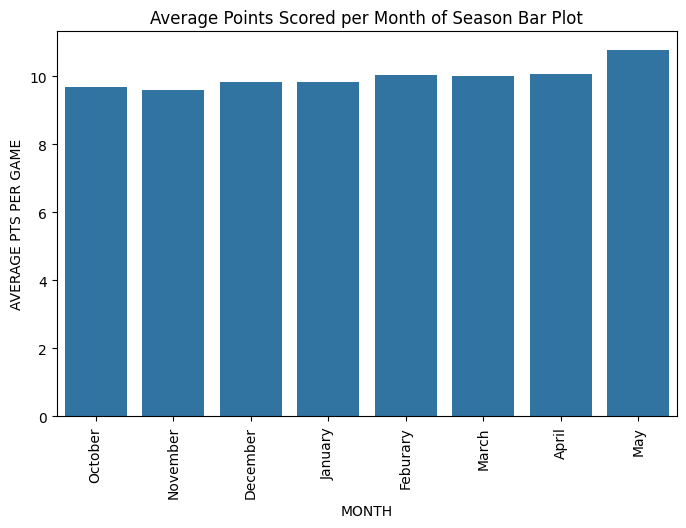

In [16]:
# Graph PTS vs MONTH - Bar Plot

months = ["October", "November","December","January","Feburary","March","April","May"]

plt.figure(figsize=(8, 5))
sns.barplot(x='MONTH', y='PTS', data=cleaned_nba_df, errorbar=None)
plt.xticks([0,1,2,3,4,5,6,7],months)
plt.title('Average Points Scored per Month of Season Bar Plot')
plt.ylabel('AVERAGE PTS PER GAME')
plt.xticks(rotation=90)
plt.show()

Note that we are looking at the average points scored per month as total points wouldn't account for the fact that some months have less games than others, especially the first and last months. Clearly, there is a slight increase in average points per game per month as the season gets later and playoff seeding becomes more important.

## Points by Home/Away

Next, since we have an indicator feature for whether or not the player is playing at home or away, it would be nice to represent the points per game scored on average for both home games and away games. A violin plot is a great choice for this as it allows us to look at the distribution of points per game for two different classes!

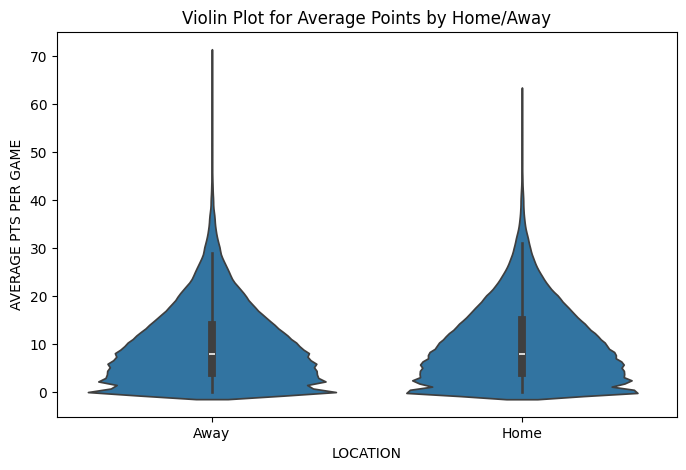

In [17]:
# Graph PTS vs LOCATION (HOME/AWAY) - Violin Plot

plt.figure(figsize=(8, 5))
sns.violinplot(x='LOCATION', y='PTS', data=cleaned_nba_df)
plt.xticks([0, 1], ['Away', 'Home'])
plt.ylabel('AVERAGE PTS PER GAME')
plt.title('Violin Plot for Average Points by Home/Away')
plt.show()

This graph shows the distribution of points based of whether the player is home or away. However, we can clearly see there are some outliers which are skewing the data. We can thus filter out games with above 50 points scored as these are VERY uncommon and regraph it.

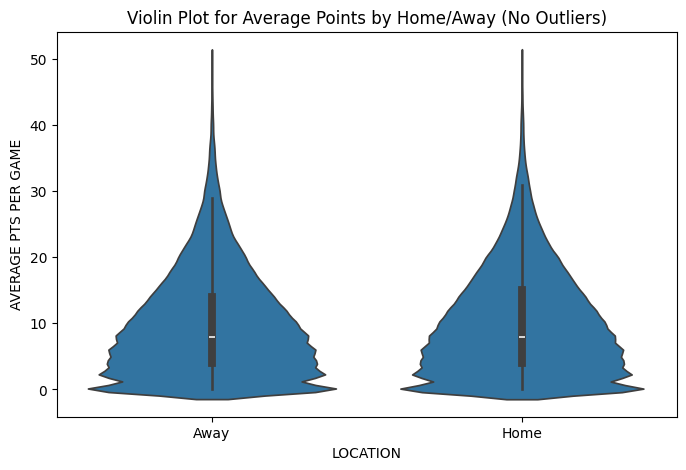

In [18]:
# Filter outlier games
final_nba_df = cleaned_nba_df[cleaned_nba_df['PTS'] <= 50]

# Replot
plt.figure(figsize=(8, 5))
sns.violinplot(x='LOCATION', y='PTS', data=final_nba_df)
plt.xticks([0, 1], ['Away', 'Home'])
plt.ylabel('AVERAGE PTS PER GAME')
plt.title('Violin Plot for Average Points by Home/Away (No Outliers)')
plt.show()

While the differences in distributions may seem very minimal to the human eye, our models might be able to pick up some valuable information here. We will later see when analyzing feature importance whether or not this ends up being a contributor to our model's predictive ability

## Points vs Rolling Average



Next, we can look at the relationship between points per game and a player's rolling average points per game over their last three. We suspect that this feature will be very helpful. A great way to represent this data is to do a scatterplot with points on the y-axis and the rolling average on the x-axis, with a line of best fit to show the general trend.

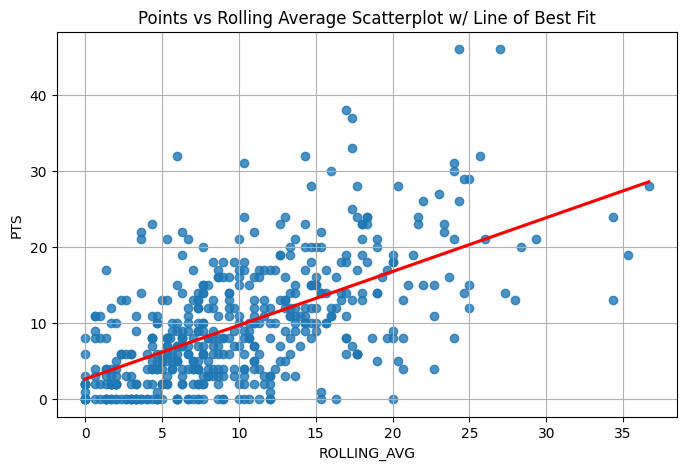

In [28]:
# Graph PTS vs ROLLING_AVG - Scatterplot w/ Line of Best Fit

# We have A LOT of data to plot on the scatterplot, so let's just get a random
# sample of about 500 points RESULTS MAY VARY

random_sample_df = final_nba_df.sample(n=500)

plt.figure(figsize=(8, 5))
sns.regplot(x='ROLLING_AVG', y='PTS', data=random_sample_df, ci=None, line_kws={'color':'red'})
plt.title('Points vs Rolling Average Scatterplot w/ Line of Best Fit')
plt.grid(True)
plt.show()

Clearly, there is a large positive correleation between these two variables, so this might end up being a very important feature. This is logical since the player's performance over their last three games should be a solid indicator of how they will perform in their next game, especially if that player is consistent.

## Points vs Opponent Points Allowed

Similar to above, we use a scatterplot to look at the relationship between points and the quality of the defense the player is playing represented through their average points per game total allowed. Again, we will use a line of best fit to see the general trend.

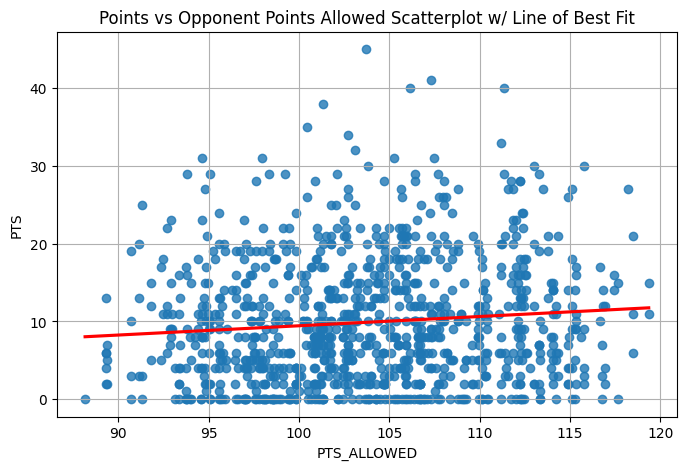

In [29]:
# Graph PTS vs REST_DAYS - Scatterplot w/ Line of Best Fit

# Random sample again RESULTS MAY VARY

random_sample_df = final_nba_df.sample(n=1000)

plt.figure(figsize=(8, 5))
sns.regplot(x='PTS_ALLOWED', y='PTS', data=random_sample_df, ci=None, line_kws={'color':'red'})
plt.title('Points vs Opponent Points Allowed Scatterplot w/ Line of Best Fit')
plt.grid(True)
plt.show()

Clearly, there is a slight positive corrleation between PTS and PTS_ALLOWED, which makes sense as a player facing a team with a defense that allows a lot of points is naturally likely to have more scoring opportunities. Additionally, we are using a small random sample of around 500 points, so the results will vary every time the code is run. Using a random sample helps make the graph more readable, but since we have no power over the players chosen, we could end up selecting lower tier players who don't score much regardless of who they're playing. This is why we have other features such as CAREER_AVG and ROLLING_AVG to account for this so that our model is able to pick up on these nuances. On that note, let's get into the modeling!

# Modeling

Now that we have collected and cleaned all of our data, as well as engineered some new features to hopefully better our predictions, it is time to get into modeling. We will begin with a simple baseline Lasso Regression model with simple brute force Grid Search tuning. Lasso Regression is very similar to Linear Regression as they are both linear models that predict a continuous target variable. However, Lasso Regression is distinct in that it allows for the possibility of only very few features actually mattering, allowing some of the other coefficients to be zero. This is useful for us as a baseline model as Lasso provides a bit more nuance than vanilla Linear Regression while still focusing on a linear relationship with our target variable PTS.

First, let's select our features, target variable, and get our training and testing splits.

### Selecting Features and Target Variable

In [21]:
# Select features (everything except PTS)
X = final_nba_df.drop('PTS', axis=1)
# Select target variable (PTS)
y = final_nba_df[['PTS']]
# Training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

In [22]:
feature_columns = list(final_nba_df.drop('PTS', axis=1).columns)

feature_columns

['PTS_ALLOWED',
 'LOCATION',
 'MONTH',
 'ROLLING_AVG',
 'CAREER_AVG',
 'REST_DAYS',
 'OPP_ATL',
 'OPP_BKN',
 'OPP_BOS',
 'OPP_CHA',
 'OPP_CHI',
 'OPP_CLE',
 'OPP_DAL',
 'OPP_DEN',
 'OPP_DET',
 'OPP_GSW',
 'OPP_HOU',
 'OPP_IND',
 'OPP_LAC',
 'OPP_LAL',
 'OPP_MEM',
 'OPP_MIA',
 'OPP_MIL',
 'OPP_MIN',
 'OPP_NJN',
 'OPP_NOH',
 'OPP_NOP',
 'OPP_NYK',
 'OPP_OKC',
 'OPP_ORL',
 'OPP_PHI',
 'OPP_PHX',
 'OPP_POR',
 'OPP_SAC',
 'OPP_SAS',
 'OPP_TOR',
 'OPP_UTA',
 'OPP_WAS',
 'SEASON_YEAR_2009-10',
 'SEASON_YEAR_2010-11',
 'SEASON_YEAR_2011-12',
 'SEASON_YEAR_2012-13',
 'SEASON_YEAR_2013-14',
 'SEASON_YEAR_2014-15',
 'SEASON_YEAR_2015-16',
 'SEASON_YEAR_2016-17',
 'SEASON_YEAR_2017-18',
 'SEASON_YEAR_2018-19',
 'SEASON_YEAR_2020-21',
 'SEASON_YEAR_2021-22']

## Lasso Regression w/ Grid Search Hyperparameter Tuning

In [23]:
# Create Model
lasso_model = Lasso()

# Parameter grid
params = {
    # primary hyperparameter, values from [0,inf) but 0 isn't advised, just use LinearRegression according to docs
    'alpha': [.0001, .01, .02, .05, .1, .2, .5, 1, 2, 5, 10],
    # method for choosing coefficients
    'selection': ['cyclic', 'random']
}

# Grid search hyperparameter tuning
grid_searcher = GridSearchCV(lasso_model, params, verbose=2, scoring='neg_mean_squared_error')

# Fit the model (warning said to use np.ravel)
grid_searcher.fit(X_train, np.ravel(y_train))

# Get best model
best_lasso = grid_searcher.best_estimator_

# Predict
predictions_train = best_lasso.predict(X_train)
predictions_test = best_lasso.predict(X_test)

# Evaluate model

# Training

lasso_mse_train = mean_squared_error(y_train, predictions_train)
lasso_r2_train = r2_score(y_train, predictions_train)

# Test

lasso_mse_test = mean_squared_error(y_test, predictions_test)
lasso_r2_test = r2_score(y_test, predictions_test)

print(f"Training Mean Squared Error: {lasso_mse_train}")
print(f"Training R^2 Score: {lasso_r2_train}")
print(f"Test Mean Squared Error: {lasso_mse_test}")
print(f"Test R^2 Score: {lasso_r2_test}")

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV] END .....................alpha=0.0001, selection=cyclic; total time=   5.0s
[CV] END .....................alpha=0.0001, selection=cyclic; total time=   5.1s
[CV] END .....................alpha=0.0001, selection=cyclic; total time=   7.2s
[CV] END .....................alpha=0.0001, selection=cyclic; total time=   5.6s
[CV] END .....................alpha=0.0001, selection=cyclic; total time=   6.8s
[CV] END .....................alpha=0.0001, selection=random; total time=  16.6s
[CV] END .....................alpha=0.0001, selection=random; total time=   5.1s
[CV] END .....................alpha=0.0001, selection=random; total time=   3.4s
[CV] END .....................alpha=0.0001, selection=random; total time=   3.8s
[CV] END .....................alpha=0.0001, selection=random; total time=   3.5s
[CV] END .......................alpha=0.01, selection=cyclic; total time=   1.1s
[CV] END .......................alpha=0.01, sel

As shown above, our Lasso Regression model seems to perform about the same for both the training and testing data. The MSE values are both around 34, which means generally the predictions are off by around 5.83 points on average. The R^2 values hover around .465, which is also fairly medicore.

The evaluation metrics being the same can be the result of many different scenarios. Best case scenario is that our model is just really good, but this is unlikely as Lasso Regression is naturally quite simple. Additionally, our predictions being off by around 6 points when the league average for points per game is typically 12 is not ideal.

The likely explanation is that we are underfitting our model due to the limited number of hyperparameters used in Lasso regression. Additionally, the model had a better MSE performance on the testing data than on the training data, which can be another indicator of underfitting.

In order to move our predictions in a better direction and to minimize underfitting, we will use a more sophisticated regression model- Random Forest, alongside Bayesian Optimization Hyperparameter Tuning.

# Random Forest Regression w/ Bayesian Optimization Hyperparameter Tuning

Random Forest is a very robust ensemble decision tree method for regression with a fundamentally different approach to building its predictions than Lasso's linear style. This fresh methodology could offer better predictions, especially given the insights we have obtained from running the previous mode. Lasso may be a little too simplistic, leading to our model to be be slighlty underfit.

 Random Forest Regression serves as a great next model selection as it is more sophisticated. However, this naturally results in the risk of overfitting, meaning we need to be careful with our hyperparameter tuning. Using Bayesian Optimization and doing some research about what parameters affect what, we can carefully select parameters to hopefully see some improvements with the predictions while mitigating overfitting.


In [24]:
# Create Random Forest model
rf = RandomForestRegressor()

# Parameter grid, help from scikit docs and https://towardsdatascience.com/mastering-random-forests-a-comprehensive-guide-51307c129cb1
params = {
    # number of trees in forest
    'n_estimators': [100,200,300,400,500],
    # very important, increased depth can increase accuracy but can also overfit
    'max_depth': [3,4,5,6,7,8],
    # number of features to use
    'max_features': [1.0, 'sqrt', 'log2'],
    # minimum number of observations for splitting
    'min_samples_split': [2,3,4,5,6,7,8],
    # minimum number of samples to be at leaf node
    'min_samples_leaf':[1,2,3,4,5]
}

# Bayesian Optimization, less cross validation so it runs faster
bayes = BayesSearchCV(rf, params, n_iter=15, cv=3, scoring='neg_mean_squared_error', verbose=2, random_state=26)

# Fit on training
bayes.fit(X_train, np.ravel(y_train))

# Best model
best_rf = bayes.best_estimator_

# Predict with the best model on test
test_predictions = best_rf.predict(X_test)
train_predictions = best_rf.predict(X_train)

# Evaluate

# Training

rf_mse_train = mean_squared_error(y_train, train_predictions)
rf_r2_train = r2_score(y_train, train_predictions)

# Test
rf_mse_test = mean_squared_error(y_test, test_predictions)
rf_r2_test = r2_score(y_test, test_predictions)

print(f"Training Mean Squared Error: {rf_mse_train}")
print(f"Training R^2 Score: {rf_r2_train}")
print(f"Test Mean Squared Error: {rf_mse_test}")
print(f"Test R^2 Score: {rf_r2_test}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=  26.2s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=  27.2s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=  25.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=  36.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=  33.8s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=  38.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=7, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total tim

As expected, we do see some improvement in both MSE scores, each now hovering around 33.5. In addition, the R^2 scores increased as well, but not by much, showing slight improvement in the amount of variance explained by the predictors of the model. Moreover, we successfully avoided overfitting through our selection of the hyperparameter space for tuning as there is no drastic change in performance between the training and testing data.

It seems that our more complicated model with hyperparameter tuning is offering slightly better predictions than our Lasso baseline, but not by much. As a result, for our third and final model we will implement an algorithm known for its higher degree of accuracy compared to Random Forest- Gradient Boosting. Before that, let's take a quick peek at the feature importance outputted by the Random Forest to get a glance at what is going on under the hood.

### Feature Importance

Since we now have finished two models, we can take advantage of the Random Forest's ability to display the most important features and visualize them.

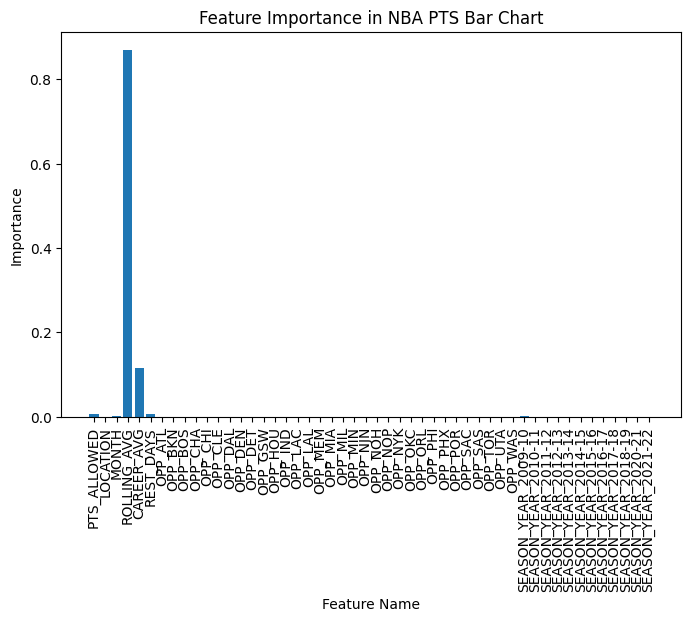

In [25]:
# Get them from the best RF model
importances = best_rf.feature_importances_

# Plot them
plt.figure(figsize=(8,5))
plt.bar(feature_columns, importances)
plt.xlabel("Feature Name")
plt.ylabel("Importance")
plt.title("Feature Importance in NBA PTS Bar Chart")
# Rotate so names are visible
plt.xticks(rotation=90)
plt.show()

According to our graph, ROLLING_AVG seems to be the most important feature by far. We saw earlier in the EDA section that ROLLING_AVG and PTS were highly positively correleated, so this graph is no surprise. After ROLLING_AVG, CAREER_AVG is the next most important feature, which also makes sense as this is a good way to ground the model based on historical data for that player. After that, REST_DAYS, MONTH, PTS_ALLOWED, and SEASON_YEAR_2009_10, all had some importance, with the rest of the features having little to none.

Despite what we initially thought, the season year and opponent being faced ended up having little to no relevance as features. The opponent team wasn't completely irrelevant, though, as PTS_ALLOWED did end up being somewhat important, which measures the quality of the defense of the opponent, which really is all that matters when it comes to scoring. Thus, it makes sense none of the other OPP features mattered much in comparison. For SEASON_YEAR, it is a bit complexing that only one of them mattered, but any importance at all can mean more accuracy with the predicitions, so while it may be small, anything helps.

Annother interseting note is that Lasso models are known for their success when only a small fraction of the features are relevant. Thus, it makes sense that our Lasso model was able to still perform well despite its simplicity relative to the Random Forest model.

Now that we are done analyzing feature importances, we can return to our third and final model- Gradient Boosting.

## Gradient Boosting Regression w/ Randomized Search Hyperparameter Tuning

Gradient Boosting Regression is another great ensemble model that can offer higher accuracy than Random Forests when the data is complex. In Random Forests, the trees are built independently, whereas with Gradient Boosting, they are built sequentially, meaning each new tree can improve on its previous decisions. However, Gradient Boosting is prone to overfitting, emphasizing the importance of our attention to hyperparameter tuning, which we will now be doing with Randomized Search.


In [26]:
# Create Gradient Boosting model
gradient = GradientBoostingRegressor(random_state=26)

# Hyperparameter grid, did research with (https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) and scikit docs
params = {
     # Tree parameters
    'max_depth': [2, 3, 4, 5, 6, 7, 8], # depth of tree
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8],  # higher values lead to less over fitting
    'min_samples_leaf': [1,2,3],  # also helps with over fitting
    'max_features': [1.0, 'sqrt', 'log2'], # randomly selects feature (1.0=auto)
     # Boosting parameters
    'learning_rate': [0.01, 0.05, .075, .09, 0.1],  # smaller is better generally
    'n_estimators': [100, 200, 300],  # number diff estimators to try
    'subsample': [0.8, 0.9, 1.0],  # keep values in between .8 and 1
}

# Create the randomizer
random = RandomizedSearchCV(gradient, params, n_iter=15, cv=3, verbose=2, scoring='neg_mean_squared_error', random_state=26)

# Fit on training (warning said to use ravel on y_train)
random.fit(X_train, np.ravel(y_train))

# Get the best model
best_gradient = random.best_estimator_

# Predict with the best model on test
test_predictions = best_gradient.predict(X_test)
train_predictions = best_gradient.predict(X_train)

# Evaluate

# Training

gradient_mse_train = mean_squared_error(y_train, train_predictions)
gradient_r2_train = r2_score(y_train, train_predictions)

# Test
gradient_mse_test = mean_squared_error(y_test, test_predictions)
gradient_r2_test = r2_score(y_test, test_predictions)

print(f"Training Mean Squared Error: {gradient_mse_train}")
print(f"Training R^2 Score: {gradient_r2_train}")
print(f"Test Mean Squared Error: {gradient_mse_test}")
print(f"Test R^2 Score: {gradient_r2_test}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END learning_rate=0.01, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=100, subsample=1.0; total time=  14.9s
[CV] END learning_rate=0.01, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=100, subsample=1.0; total time=  15.8s
[CV] END learning_rate=0.01, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=100, subsample=1.0; total time=  15.0s
[CV] END learning_rate=0.05, max_depth=6, max_features=1.0, min_samples_leaf=3, min_samples_split=4, n_estimators=100, subsample=0.9; total time= 1.3min
[CV] END learning_rate=0.05, max_depth=6, max_features=1.0, min_samples_leaf=3, min_samples_split=4, n_estimators=100, subsample=0.9; total time= 1.4min
[CV] END learning_rate=0.05, max_depth=6, max_features=1.0, min_samples_leaf=3, min_samples_split=4, n_estimators=100, subsample=0.9; total time= 1.4min
[CV] END learning_

As expected, we see another slight increase in accuracy with our Gradeint Boosting model. Again, we seem to have mainly minimized overfitting as there is no drastic difference in performance between the training and testing data. Our MSE for the testing data is at an all time low of 33.4, which is solid since our baseline was 34.1 Additionally, our R^2 value increased from just sover .46 to .475 in our baseline.

The results for this model were as we expected- slightly better than Random Forest with a tad of overfitting, and even better than our baseline, Lasso regression. We can now analyze the performance of all three models below.

# Overall Results

Now that we have implemented three different types of supervised learning regression models, we can create a simple line chart to display how our two main performance metrics, MSE and R^2, varied throughout the models.

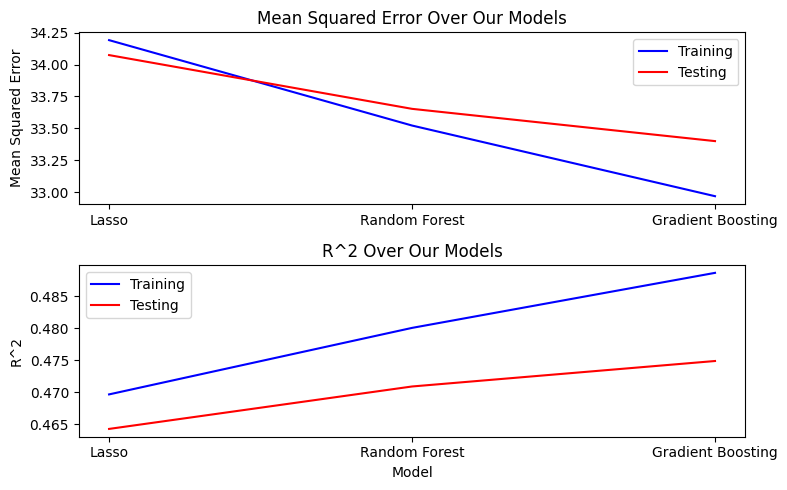

In [27]:
# Line Chart Graphing R^2 and MSE across the 3 models for both testing and training

# MSE values for training and testing
train_mse = [lasso_mse_train, rf_mse_train, gradient_mse_train]
test_mse = [lasso_mse_test, rf_mse_test, gradient_mse_test]

# R^2 values for training and testing
train_r2 = [lasso_r2_train, rf_r2_train, gradient_r2_train]
test_r2 = [lasso_r2_test, rf_r2_test, gradient_r2_test]

# Indexing by Model
indices = ['Lasso', 'Random Forest', 'Gradient Boosting']

# Figure with two subplots
fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(8,5))

# MSE Subplot
sns.lineplot(x=indices, y=train_mse, ax=axis1, label="Training", color='blue')
sns.lineplot(x=indices, y=test_mse, ax=axis1, label="Testing", color='red')
axis1.set_title('Mean Squared Error Over Our Models')
axis1.set_ylabel('Mean Squared Error')
axis1.legend()

# R^2 Subplot
sns.lineplot(x=indices, y=train_r2, ax=axis2, label="Training", color='blue')
sns.lineplot(x=indices, y=test_r2, ax=axis2, label="Testing", color='red')
axis2.set_title('R^2 Over Our Models')
axis2.set_xlabel('Model')
axis2.set_ylabel('R^2')
axis2.legend()

# Display
plt.tight_layout()
plt.show()


# Conclusion and Discussion

The NBA is hard to predict. In the end, all three of our models performed about the same, with MSE values for both training and testing hovering around 33-34 and R^2 values around .47-.48. In general, our MSE values indicate that our predictions are on average off by about 5.8 points. The fact that our three diverse models hovered around this value is an indication that there may NOT be much more improvement left to do with our current computational power and dataset. Furthermore, it is logical that our models didn't improve drastically after the linear style Lasso Regression model, as the most important feature by a mile, ROLLING_AVG, which we discovered using the Random Forest model, seemed to have a linear relationship with PTS as shown in the EDA section.

Concerning potential stakeholders, whether it be those trying to predict player performances for monetary gain through sports betting, coaches trying to predict player performances in important games, or sports analysts trying to get a leg up on the competition, the implications of this model are very subtle and go hand and hand with the main limitation of this project. While predictions off by 6 points on average may seem bad for a league with a 12 point average per player, it is important to keep in mind the fact that the majority of NBA players are not scoring points at a **consistent** level. For instance, there may be a random bench player who barely gets in the game for a few weeks totaling no points, and then randomly breaks out and drops 20. Obviously, with the data publically available to us and no information about NBA coach gameplans, there is no way for our model to predict this. On the other hand, with talented players like LeBron James and Steph Curry who are known for their consistency and high performances, the models will be able to pick up on scoring patterns throughout their career. Additionally, predictions being off by around 5.8 points on average seem a lot less bad when some of these players are consistenly dropping more than 30 points a game.

While our model can't exactly tell how many points a player will score in a given game, and if it did we could drop out of school and make a living purely off sports betting with it, the results of our model can give a general indication for how players are going to play. This indication is worth even more if the player is known to be consistent. Even models made by the NBA and ESPN to predict player points or what teams are going to be the best are rarely ever completely correct. The fact that we are even able to get within 5-6 points for our predictions given the dataset is a huge testimony to how amazing these models are.

For potential improvement, there are a few changes/additions that naturally could help with the model's ability to predict. First and foremost- computational power. It takes hours and hours to run the models with the hyperparameter tuning, even with the number of iterations is relatively small. While the hyperparameter tuning that we implemented surely improved the results by finding the best parameters, there is a bid trade off in runtime which took up a lot of time and led us to not be able to experiment as much. Second, the dataset. We performed a lot of feature engineering to create features such as a rolling points average to represent how a player has been performing recently, career point average to see how a player has been performing historically, an indicator of whether the game is home or away, how late in the season the game is being played, and so on. However, more work can always be done, and a deeper dive into NBA analytics could uncover some more features to engineer. Specifically, to improve the model in the future, incorporating more statistics similar to the most important features indentified by the Random Forest model, for example different type of short term window metrics such as ROLLING_AVG, could benefit the accuracy of our predictions. Lastly, with more time we could've looked into implementing a neural network to understand what factors most improve model performance and why, as well as to test an entirely different type of predictor.

In the end, this project was a great learning experience that provides useful insights into the general forecasting of player point scoring that can be used alongside other pieces of information for sports bettors, analysts, and coaches alike.



# THANK YOU!!

Grant Wells, Ayo Tobun